# ***DS Lab - Clustering***

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
import warnings

rstate = 1234
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
import numpy as np 
from sklearn import metrics
import pandas as pd 
!pip install scikit-learn-extra
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import pairwise_distances_argmin
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from numpy.random import rand

In [ ]:
df = gc.open_by_url("https://docs.google.com/spreadsheets/d/1tC3dqvepIuWjv088p4gTdF2mFVNKJHnLAgoK7__tfRc/edit?usp=sharing")
df = df.worksheet("DatasetClientClustering").get_all_values()
CC = pd.DataFrame.from_records(df[1:], columns=df[0])
CC.set_index(CC.columns[0], inplace = True)

Functions

In [ ]:
def purity(y_true, y_predicted):
    """
    Input:
            y_true: true labels, y_predicted: predicted labels 
          
    Output:
            the purity metric


    step1: call sklearn's confusion matrix and store it
    step2: select the max value from each column and store it
    step3: sum up the max values and divide it by the total number of data points. Store it in a variable called purity
    """
    #write your code here
    
    conf_mat = confusion_matrix(y_true, y_predicted)
    max_value = conf_mat.max(0)
    purity = sum(max_value) / len(y_true)

    return purity 

In [ ]:
def evaluation_metrics(X, predicted_labels, metric, algorithm, true_labels, rstate = rstate):
    """
    Input:
            X:the dataset, predicted_labels: predicted labels, 
            metric: to calculate silhouette (ex "manhatan" or "euclidean"),
            true_labels: class label, random_state: RSTATE
          
    Output:
            the evaluation metrics dataframe

    step1: calculate silhouette with metric equal to the metric passed in the parameters of the function, random_state = rstate
    step2: call the purity function that you defined above 
    step3: create a dataframe to store the above(named dataframe_with_metrics), with column names ['Metric','Value','Algorithm'] and in each row the name of the algorithm the metric refers to    
    """
    #write your code here

    s_s = metrics.silhouette_score(X, predicted_labels, metric = metric, random_state = rstate) 
    pur = purity(true_labels, predicted_labels)

    metrics_names = ["S_S", "Purity"]
    values = [s_s, pur]
    alg = [algorithm, algorithm]

    dataframe_with_metrics = list(zip(metrics_names,values, alg))
    dataframe_with_metrics = pd.DataFrame(dataframe_with_metrics, columns=['Metric','Value','Algorithm'])

    return dataframe_with_metrics

In [ ]:
def elbow_method(X, max_range_for_elbow, mod, rstate = rstate):
    """
    Input: 
        X:the dataset, max_range_for_elbow:the max number of clusters you want the elbow method to run, random_state: RSTATE. 

    step1: 
        store in K, a sequence of numbers from 1 to max_range_of_elbow+1
    step2: 
        create an empty list where you will store the inertia
    step3: 
        in a for loop that goes through the values of K one by one, run Kmeans for each of these values with random_state=rstate
    step4: 
        calculate the inertia(it's stored as an attribure in Kmeans object) of each clustering and store it in the list from step 2
    step5: 
        plot the resulting elbow, in x-axis: the number of clusters and in y-axis: the inertia
    """ 

    K = range(1, max_range_for_elbow + 1)
    inertia = []
    

    for i in K:
        if mod == "kmeans":
            kmeans = KMeans(n_clusters=i,random_state=rstate)
            kmeans.fit_predict(X)
            inertia.append(kmeans.inertia_)
        elif mod == "kmedoids":
            kmedoids = KMedoids(n_clusters=i, random_state=rstate)
            kmedoids.fit_predict(X)
            inertia.append(kmedoids.inertia_)
        else:
            pass
        

    plt.figure(figsize=(8,6))
    plt.plot(K, inertia,'b')
    plt.scatter(K, inertia)

    plt.title('The Elbow method showing the optimal k')
    plt.show()

# *Cleaning Starts*

### *What needs to be done:*
1) Cleanining the .00 digit at the end of most of the values

2) This creates problem by dropping 0. Na to be fixed

3) Correct all the categorical values

4) Set all correct datatype

5) Porftfolio composition has to be normalized

6) Discretize the features

In [ ]:
CC.head()

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeHighLow,Sex,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,PanicMood,ClientDateStart,NoTrustInBanks,Prov,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
ClientID,,,,,,,,,,,,,,,,,,,,,,,,
Client1,9959217.54.00,14631.13.00,1298072.17.00,120.07.00,4761904.46.00,2474437.38.00,0,1,13719,22,1320243.21.00,13291858.41.00,3406690.03.00,10562696.16.00,1913384.29.00,0,2015,0,PA,9.33,7.07,0,0,0
Client2,8358106.46.00,1038165.19.00,380810.27.00,124.07.00,11904761.54.00,2546012.16.00,0,1,45973,61,4693363.59.00,2910995.38.00,2559984.33.00,10487635.19.00,8422698.58.00,0,2016,0,RM,89.01.00,74.26.00,2.04,0,0.07
Client3,9235137.56.00,0,11263161.34.00,0.5,8730158.44.00,4059304.42.00,0,0,10233,24,206691.01.00,14716590.19.00,1282680.03.00,11061285.41.00,1165403.21.00,0,2015,0,BS,0,0,0,0,1
Client4,7345484.24.00,539018.16.00,9397162.39.00,96.36.00,10317460.19.00,1492842.32.00,0,0,25144,46,3493499.56.00,9136849.59.00,3770298.12.00,3633642.06.00,6927833.08.00,0,2015,0,RE,107.08.00,2.02,6.47,32.23.00,0.02
Client5,9008797.36.00,630873.26.00,156939.07.00,83.51.00,7142857.09.00,2709611.27.00,0,0,222892,57,5334771.04.00,15127392.43.00,11732273.23.00,8438590.26.00,5584275.34.00,0,2015,0,MI,28.27.00,45.01.00,88.52.00,0.45,3.35


In [ ]:
col = list(CC.columns)
stripcol = col[:6] + col[10:15] + col[19:]
catecol = [ele for ele in col if ele not in stripcol] 

In [ ]:
CC[stripcol] = CC[stripcol].applymap(lambda x: x.rstrip(".00")) # Removed pattern that created troubles with the float convertion

In [ ]:
# Data like 6,06E+ corrected with 6,06E+ = 6,05638
# found new errors "3,03E+" =" 3,02819

# Error consisting in the presence of comma and E+

CC['PortfolioRisk'] = CC['PortfolioRisk'].replace("6,06E+","6.05638")
CC['PortfolioRisk'] = CC['PortfolioRisk'].replace("3,03E+","3.02819")

In [ ]:
CC[stripcol] = CC[stripcol].apply(pd.to_numeric)

In [ ]:
CC[stripcol] = CC[stripcol].fillna(0)

step 1 & 2 completed

In [ ]:
CC[catecol].head()

,IncomeHighLow,Sex,AuM,Age,PanicMood,ClientDateStart,NoTrustInBanks,Prov
ClientID,,,,,,,,
Client1,0,1,13719,22,0,2015,0,PA
Client2,0,1,45973,61,0,2016,0,RM
Client3,0,0,10233,24,0,2015,0,BS
Client4,0,0,25144,46,0,2015,0,RE
Client5,0,0,222892,57,0,2015,0,MI


In [ ]:
CC["IncomeHighLow"].loc[CC["IncomeHighLow"]!="1"] = "0"
CC["Sex"].loc[CC["Sex"]!="1"] = "0"
CC["PanicMood"].loc[CC["PanicMood"]!="-1"] = "0"
CC["PanicMood"].loc[CC["PanicMood"]=="-1"] = "1"
CC["NoTrustInBanks"].loc[CC["NoTrustInBanks"]!="1"] = "0"

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
CC[catecol] = CC[catecol].astype("category")
CC[["Age"]] = CC["Age"].astype("int")
CC[["AuM"]] = CC["AuM"].astype("int")
CC["ClientDateStart"] = CC["ClientDateStart"].astype("int")

In [ ]:
CC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, Client1 to Client5000
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   RiskPropension             5000 non-null   float64 
 1   PortfolioRisk              5000 non-null   float64 
 2   ClientInvestmentHorizon    5000 non-null   float64 
 3   PortfolioHorizon           5000 non-null   float64 
 4   ClientKnowledgeExperience  5000 non-null   float64 
 5   ClientPotentialIndex       5000 non-null   float64 
 6   IncomeHighLow              5000 non-null   category
 7   Sex                        5000 non-null   category
 8   AuM                        5000 non-null   int64   
 9   Age                        5000 non-null   int64   
 10  IncomeNeed                 5000 non-null   float64 
 11  LongTermCareNeed           5000 non-null   float64 
 12  ProtectionNeed             5000 non-null   float64 
 13  PensionNeed               

step 3 & 4 completed

In [ ]:
# Normalizing portfolio data
Portfolio = CC[['BondInvestments','EquityInvestments','MoneyMarketInvestments','OtherInvestments','Cash']]
Portfolio["Total"] = Portfolio.sum(axis = 1)
Portfolio.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash,Total
ClientID,,,,,,
Client1,9.33,7.07,0.00,0.00,0.00,16.40
Client2,89.01,74.26,2.04,0.00,0.07,165.38
Client3,0.00,0.00,0.00,0.00,1.00,1.00
Client4,107.08,2.02,6.47,32.23,0.02,147.82
Client5,28.27,45.01,88.52,0.45,3.35,165.60


In [ ]:
Portfolio = Portfolio.div(Portfolio["Total"], axis="index")
Portfolio.head()

,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash,Total
ClientID,,,,,,
Client1,0.568902,0.431098,0.000000,0.000000,0.000000,1.0
Client2,0.538215,0.449026,0.012335,0.000000,0.000423,1.0
Client3,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
Client4,0.724395,0.013665,0.043769,0.218035,0.000135,1.0
Client5,0.170713,0.271800,0.534541,0.002717,0.020229,1.0


In [ ]:
CC.update(Portfolio)
CC.head()

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeHighLow,Sex,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,PanicMood,ClientDateStart,NoTrustInBanks,Prov,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
ClientID,,,,,,,,,,,,,,,,,,,,,,,,
Client1,9959217.54,14631.13,1298072.17,120.07,4761904.46,2474437.38,0,1,13719,22,1320243.21,13291858.41,3406690.03,10562696.16,1913384.29,0,2015,0,PA,0.568902,0.431098,0.000000,0.000000,0.000000
Client2,8358106.46,1038165.19,380810.27,124.07,11904761.54,2546012.16,0,1,45973,61,4693363.59,2910995.38,2559984.33,10487635.19,8422698.58,0,2016,0,RM,0.538215,0.449026,0.012335,0.000000,0.000423
Client3,9235137.56,0.00,11263161.34,0.50,8730158.44,4059304.42,0,0,10233,24,206691.01,14716590.19,1282680.03,11061285.41,1165403.21,0,2015,0,BS,0.000000,0.000000,0.000000,0.000000,1.000000
Client4,7345484.24,539018.16,9397162.39,96.36,10317460.19,1492842.32,0,0,25144,46,3493499.56,9136849.59,3770298.12,3633642.06,6927833.08,0,2015,0,RE,0.724395,0.013665,0.043769,0.218035,0.000135
Client5,9008797.36,630873.26,156939.07,83.51,7142857.09,2709611.27,0,0,222892,57,5334771.04,15127392.43,11732273.23,8438590.26,5584275.34,0,2015,0,MI,0.170713,0.271800,0.534541,0.002717,0.020229


step 5 completed

In [ ]:
CCdiscrete=CC.copy()

In [ ]:
CCquantiles = CCdiscrete.quantile([0, .25, .5, .75, 1], axis = 0) 
CCquantiles

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,ClientDateStart,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
0.00,1.000000e+00,0.000000e+00,1.110000e+00,5.000000e-01,1.00,0.00,10000.00,2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1983.0,0.000000,0.000000,0.000000,0.000000,0.000000
0.25,5.982184e+06,3.037022e+05,7.450000e+00,8.210000e+00,7142857.09,1370143.09,27736.50,43.0,3.050067e+06,3.129001e+06,3.198620e+06,1.803381e+06,4.153651e+06,2015.0,0.270871,0.036448,0.000000,0.000000,0.000664
0.50,7.664197e+06,6.333966e+05,3.313704e+05,6.026500e+01,8730158.44,3118609.24,66965.00,54.0,4.704857e+06,7.237119e+06,4.657615e+06,8.052457e+06,8.307025e+06,2015.0,0.527485,0.193363,0.018475,0.000000,0.023818
0.75,9.468322e+06,9.454267e+05,1.176774e+06,1.163050e+02,10317460.19,5470347.39,163918.25,68.0,6.403725e+06,1.199532e+07,7.663412e+06,9.878834e+06,1.028412e+07,2016.0,0.720821,0.369763,0.058413,0.042331,0.163665
1.00,1.610798e+07,1.195581e+07,1.659202e+07,1.513371e+07,15079365.05,15112474.26,14366700.00,103.0,1.665133e+07,1.629115e+07,1.658844e+07,1.654493e+07,1.645249e+07,2016.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# this system creates problem with extreme values
CCdiscrete["RiskPropension"] = pd.cut(CCdiscrete["RiskPropension"], bins=CCquantiles["RiskPropension"],labels=np.arange(4), right=False)

CCdiscrete["PortfolioRisk"] = pd.cut(CCdiscrete["PortfolioRisk"], bins=CCquantiles["PortfolioRisk"],labels=np.arange(4), right=False)

CCdiscrete["ClientInvestmentHorizon"] = pd.cut(CCdiscrete["ClientInvestmentHorizon"], bins=CCquantiles["ClientInvestmentHorizon"],labels=np.arange(4), right=False)

CCdiscrete["PortfolioHorizon"] = pd.cut(CCdiscrete["PortfolioHorizon"], bins=CCquantiles["PortfolioHorizon"],labels=np.arange(4), right=False)

CCdiscrete["ClientKnowledgeExperience"] = pd.cut(CCdiscrete["ClientKnowledgeExperience"], bins=CCquantiles["ClientKnowledgeExperience"],labels=np.arange(4), right=False)

CCdiscrete["ClientPotentialIndex"] = pd.cut(CCdiscrete["ClientPotentialIndex"], bins=CCquantiles["ClientPotentialIndex"],labels=np.arange(4), right=False)

CCdiscrete["IncomeNeed"] = pd.cut(CCdiscrete["IncomeNeed"], bins=CCquantiles["IncomeNeed"],labels=np.arange(4), right=False)

CCdiscrete["LongTermCareNeed"] = pd.cut(CCdiscrete["LongTermCareNeed"], bins=CCquantiles["LongTermCareNeed"],labels=np.arange(4), right=False)

CCdiscrete["ProtectionNeed"] = pd.cut(CCdiscrete["ProtectionNeed"], bins=CCquantiles["ProtectionNeed"],labels=np.arange(4), right=False)

CCdiscrete["PensionNeed"] = pd.cut(CCdiscrete["PensionNeed"], bins=CCquantiles["PensionNeed"],labels=np.arange(4), right=False)

CCdiscrete["InheritanceIndex"] = pd.cut(CCdiscrete["InheritanceIndex"], bins=CCquantiles["InheritanceIndex"],labels=np.arange(4), right=False)

In [ ]:
bins = [0,18,30,50,70,200]
labels = [18,30,50,70,100]
CCdiscrete["Age"] = pd.cut(CCdiscrete["Age"], bins=bins, labels=labels, right=False)

CCdiscrete.head(10)

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeHighLow,Sex,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,PanicMood,ClientDateStart,NoTrustInBanks,Prov,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
ClientID,,,,,,,,,,,,,,,,,,,,,,,,
Client1,3,0,3,3,0,1,0,1,13719,30,0,3,1,3,0,0,2015,0,PA,0.568902,0.431098,0.000000,0.000000,0.000000
Client2,2,3,2,3,3,1,0,1,45973,70,1,0,0,3,2,0,2016,0,RM,0.538215,0.449026,0.012335,0.000000,0.000423
Client3,2,0,3,0,2,2,0,0,10233,30,0,3,0,3,0,0,2015,0,BS,0.000000,0.000000,0.000000,0.000000,1.000000
Client4,1,1,3,2,3,1,0,0,25144,50,1,2,1,1,1,0,2015,0,RE,0.724395,0.013665,0.043769,0.218035,0.000135
Client5,2,1,1,2,1,1,0,0,222892,70,2,3,3,2,1,0,2015,0,MI,0.170713,0.271800,0.534541,0.002717,0.020229
Client6,2,0,2,0,3,2,0,1,34746,70,1,0,3,1,2,0,2015,0,TO,0.525482,0.248675,0.000000,0.000000,0.225843
Client7,0,3,2,2,3,3,0,1,313942,70,3,1,3,3,3,0,2014,0,VR,0.583092,0.304891,0.069686,0.042331,0.000000
Client8,0,0,0,3,2,1,0,1,124883,100,3,1,2,0,3,0,2015,0,NA,0.000000,0.000000,0.559281,0.318851,0.121868
Client9,0,0,0,0,NaN,0,0,1,75549,100,3,1,3,1,3,0,2016,1,SV,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
CCdiscrete[stripcol] = CCdiscrete[stripcol].fillna(3)

In [ ]:
CCdiscrete.info() # something is off

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, Client1 to Client5000
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   RiskPropension             5000 non-null   category
 1   PortfolioRisk              5000 non-null   category
 2   ClientInvestmentHorizon    5000 non-null   category
 3   PortfolioHorizon           5000 non-null   category
 4   ClientKnowledgeExperience  5000 non-null   category
 5   ClientPotentialIndex       5000 non-null   category
 6   IncomeHighLow              5000 non-null   category
 7   Sex                        5000 non-null   category
 8   AuM                        5000 non-null   int64   
 9   Age                        5000 non-null   category
 10  IncomeNeed                 5000 non-null   category
 11  LongTermCareNeed           5000 non-null   category
 12  ProtectionNeed             5000 non-null   category
 13  PensionNeed               

step 6 completed

# *Exploratory Analysis*

### *What needs to be done:*
1) Describing the features (i.e. Age distribution - risk propensity)

2) Correlation matrix between the descriptive features

3) Portfolio composition analysis (groupby categories / correlations)

4) PCA


In [ ]:
CC.describe()

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,AuM,Age,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex,ClientDateStart,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.396504e+06,7.042769e+05,1.425454e+06,2.182482e+04,8.427571e+06,3.741721e+06,1.898872e+05,54.575400,5.141793e+06,7.180190e+06,5.730977e+06,6.302976e+06,7.372544e+06,2014.056400,0.490003,0.237376,0.050387,0.041414,0.176820
std,3.057230e+06,6.591189e+05,3.117877e+06,4.624247e+05,3.850639e+06,3.051749e+06,5.234644e+05,17.574325,3.362337e+06,4.641868e+06,3.744721e+06,4.240588e+06,3.830358e+06,5.327898,0.296728,0.224041,0.103786,0.094399,0.308302
min,1.000000e+00,0.000000e+00,1.110000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+04,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1983.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.982184e+06,3.037022e+05,7.450000e+00,8.210000e+00,7.142857e+06,1.370143e+06,2.773650e+04,43.000000,3.050067e+06,3.129001e+06,3.198620e+06,1.803381e+06,4.153651e+06,2015.000000,0.270871,0.036448,0.000000,0.000000,0.000664
50%,7.664197e+06,6.333966e+05,3.313704e+05,6.026500e+01,8.730158e+06,3.118609e+06,6.696500e+04,54.000000,4.704857e+06,7.237119e+06,4.657615e+06,8.052457e+06,8.307025e+06,2015.000000,0.527485,0.193363,0.018475,0.000000,0.023818
75%,9.468322e+06,9.454267e+05,1.176774e+06,1.163050e+02,1.031746e+07,5.470347e+06,1.639182e+05,68.000000,6.403725e+06,1.199532e+07,7.663412e+06,9.878834e+06,1.028412e+07,2016.000000,0.720821,0.369763,0.058413,0.042331,0.163665
max,1.610798e+07,1.195581e+07,1.659202e+07,1.513371e+07,1.507937e+07,1.511247e+07,1.436670e+07,103.000000,1.665133e+07,1.629115e+07,1.658844e+07,1.654493e+07,1.645249e+07,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Suggest to make some subplots (like 3/4)

In [ ]:
#fig,axs = plt.subplots(3,4,figsize=(12,9),sharey=True)

#for ax,feat in zip(axs.flatten(),cat_features):
 #   ax.hist(tdf[feat],align='left')
  #  ax.set_title(feat)
#plt.tight_layout()

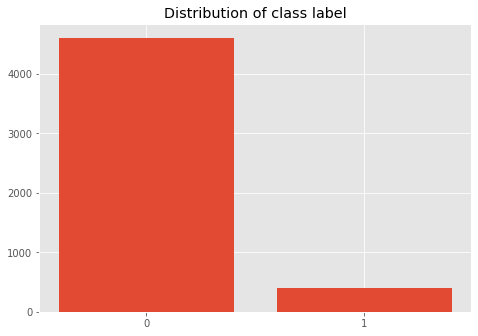

In [ ]:

plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(CC["IncomeHighLow"].unique(), CC["IncomeHighLow"].value_counts())
ax.set_title("Distribution of class label")
ax.set_xticks(CC["IncomeHighLow"].unique())


ax.grid(b=True)

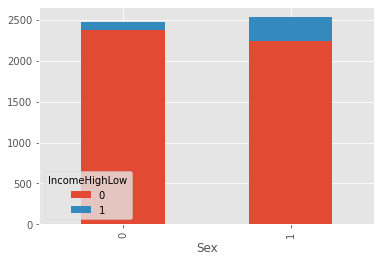

In [ ]:
sex_by_class = CC.groupby("Sex").IncomeHighLow.value_counts()
sex_by_class.unstack().plot(kind='bar', stacked= True)

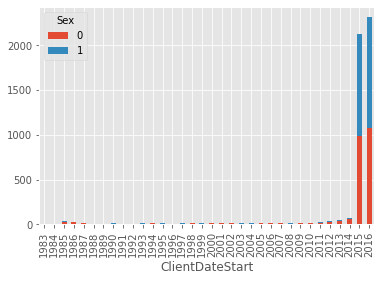

In [ ]:
by_age= CC.groupby(["ClientDateStart"]).Sex.value_counts()
by_age.unstack().plot(kind='bar', stacked=True )

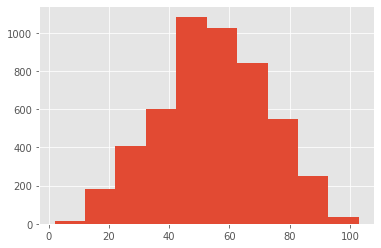

In [ ]:
plt.hist(CC["Age"],)
plt.show()

In [ ]:
AuMdistrib = CCdiscrete.groupby(["Age","IncomeHighLow"]).sum()["AuM"].reset_index()
#plt.hist(AuMdistrib["AuM"],bins = AuMdistrib["Age"])
AuMdistrib

,Age,IncomeHighLow,AuM
0,18,0,2865922
1,18,1,156104
2,30,0,17567302
3,30,1,967719
4,50,0,146208469
5,50,1,15657298
6,70,0,303983721
7,70,1,106972299
8,100,0,257740942
9,100,1,97316134


In [ ]:
CCdiscrete.groupby(["Age"]).mean()[["BondInvestments","EquityInvestments","MoneyMarketInvestments","OtherInvestments","Cash"]]

,BondInvestments,EquityInvestments,MoneyMarketInvestments,OtherInvestments,Cash
Age,,,,,
18,0.507756,0.136885,0.021184,0.002337,0.331838
30,0.378889,0.200646,0.038024,0.027697,0.354745
50,0.449216,0.240696,0.046223,0.037015,0.221352
70,0.514351,0.255615,0.057272,0.045031,0.122730
100,0.545554,0.217568,0.049370,0.047805,0.137820


In [ ]:
CCdiscrete.groupby(["Age","IncomeHighLow"]).mean()[["BondInvestments","EquityInvestments","MoneyMarketInvestments","OtherInvestments","Cash"]]
# young people have a ton of useless cash(?) savings for the house??? -> the amounts decline with the age
# yet, a lot of bonds everywhere
# Money investments never over 6/7%

BondInvestments  ...      Cash
Age IncomeHighLow                   ...          
18  0                     0.501176  ...  0.344671
    1                     0.632778  ...  0.088012
30  0                     0.379217  ...  0.356518
    1                     0.358455  ...  0.244553
50  0                     0.446733  ...  0.226609
    1                     0.494917  ...  0.124628
70  0                     0.519135  ...  0.126652
    1                     0.478070  ...  0.092990
100 0                     0.548171  ...  0.140070
    1                     0.511091  ...  0.108192

[10 rows x 5 columns]

In [ ]:
CCdiscrete.groupby(["Age","ClientInvestmentHorizon"]).mean()[["BondInvestments","EquityInvestments","MoneyMarketInvestments","OtherInvestments","Cash"]]
# The investment horizon does not seem to change the portfolio composition that much

BondInvestments  ...      Cash
Age ClientInvestmentHorizon                   ...          
18  0                                    NaN  ...       NaN
    1                               0.577441  ...  0.198286
    2                               0.569719  ...  0.286597
    3                               0.355453  ...  0.525711
30  0                                    NaN  ...       NaN
    1                               0.416803  ...  0.299226
    2                               0.330720  ...  0.411097
    3                               0.402623  ...  0.334088
50  0                               0.272373  ...  0.464859
    1                               0.442579  ...  0.231340
    2                               0.438022  ...  0.221493
    3                               0.466717  ...  0.211400
70  0                               0.529894  ...  0.125093
    1                               0.520544  ...  0.123913
    2                               0.515840  ...  0.132996
    3                               0.498771  ...  0.109807
100 0                               0.548228  ...  0.133642
    1                               0.498728  ...  0.202053
    2                                    NaN  ...       NaN
    3                               0.810092  ...  0.028325

[20 rows x 5 columns]

In [ ]:
CCdiscrete.groupby(["RiskPropension","IncomeHighLow"]).mean()[["BondInvestments","EquityInvestments","MoneyMarketInvestments","OtherInvestments","Cash"]]
# the high income reduces the amount of cash holded in the portfolio (which is diverted to equity)

BondInvestments  ...      Cash
RiskPropension IncomeHighLow                   ...          
0              0                     0.485711  ...  0.180202
               1                     0.483550  ...  0.109947
1              0                     0.519426  ...  0.127589
               1                     0.468368  ...  0.096065
2              0                     0.503974  ...  0.163567
               1                     0.518527  ...  0.058661
3              0                     0.454409  ...  0.256366
               1                     0.460627  ...  0.210140

[8 rows x 5 columns]

In [ ]:
CCdiscrete.groupby(["RiskPropension","IncomeHighLow"]).size()

RiskPropension  IncomeHighLow
0               0                1167
                1                  83
1               0                1125
                1                 125
2               0                1126
                1                 124
3               0                1190
                1                  60
dtype: int64

In [ ]:
CCdiscrete.groupby(["RiskPropension","PortfolioRisk"]).mean()[["BondInvestments","EquityInvestments","MoneyMarketInvestments","OtherInvestments","Cash"]]
# Low risk tolerance increases significantly the amount of cash holded in the portfolio 
# The composition is the following (Portfolio risk = 0 -> shitton of cash, Portfolio risk = 1 -> shitton of bond, Portfolio risk = 2 -> balanced, Portfolio risk = 0 -> shitton of equity,)

BondInvestments  ...      Cash
RiskPropension PortfolioRisk                   ...          
0              0                     0.311712  ...  0.482144
               1                     0.642066  ...  0.101405
               2                     0.541417  ...  0.055569
               3                     0.454000  ...  0.054743
1              0                     0.387537  ...  0.331892
               1                     0.645214  ...  0.102992
               2                     0.570428  ...  0.057404
               3                     0.446909  ...  0.055678
2              0                     0.382303  ...  0.401459
               1                     0.633996  ...  0.104399
               2                     0.559374  ...  0.072363
               3                     0.431110  ...  0.059455
3              0                     0.326497  ...  0.517519
               1                     0.609996  ...  0.173356
               2                     0.522281  ...  0.114558
               3                     0.379045  ...  0.116172

[16 rows x 5 columns]

In [ ]:
CCdiscrete.groupby(["RiskPropension","PortfolioRisk"]).size()
# given the size of the matches, there is a clear uncorrelation between the risk propension of the portfolio risk
# There are still a lot of clients with high risk profile but with low risk portfolios (also true the opposite -> low risk profiles but high risk portfolios)
#sns.displot(CC["PortfolioRisk"])

RiskPropension  PortfolioRisk
0               0                320
                1                299
                2                329
                3                302
1               0                260
                1                286
                2                348
                3                356
2               0                288
                1                321
                2                326
                3                315
3               0                382
                1                342
                2                249
                3                277
dtype: int64

step 1 & 3 completed

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


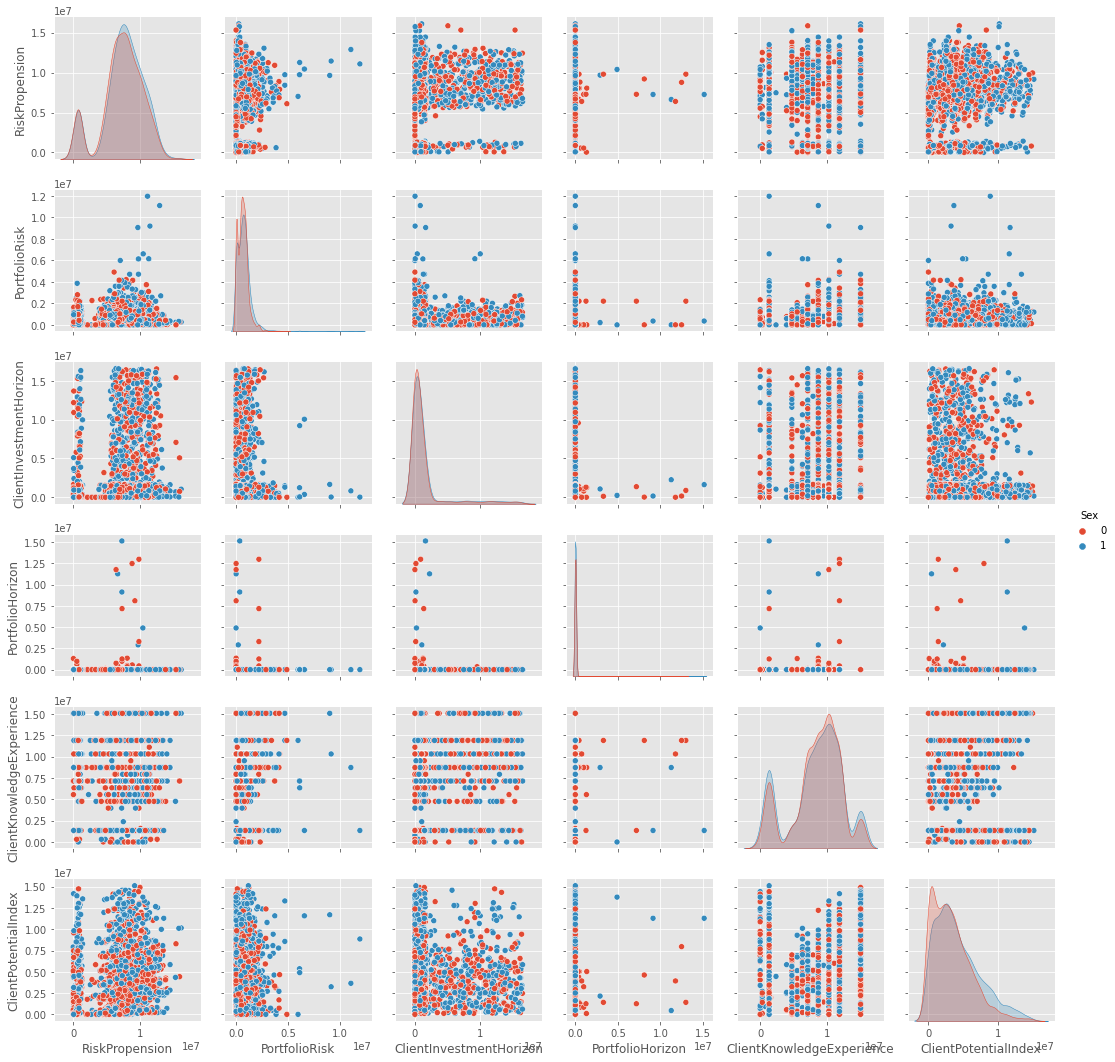

In [ ]:
sns.pairplot(CC[["Sex",'RiskPropension',
 'PortfolioRisk',
 'ClientInvestmentHorizon',
 'PortfolioHorizon',
 'ClientKnowledgeExperience',
 'ClientPotentialIndex']],hue='Sex',size=2.5)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


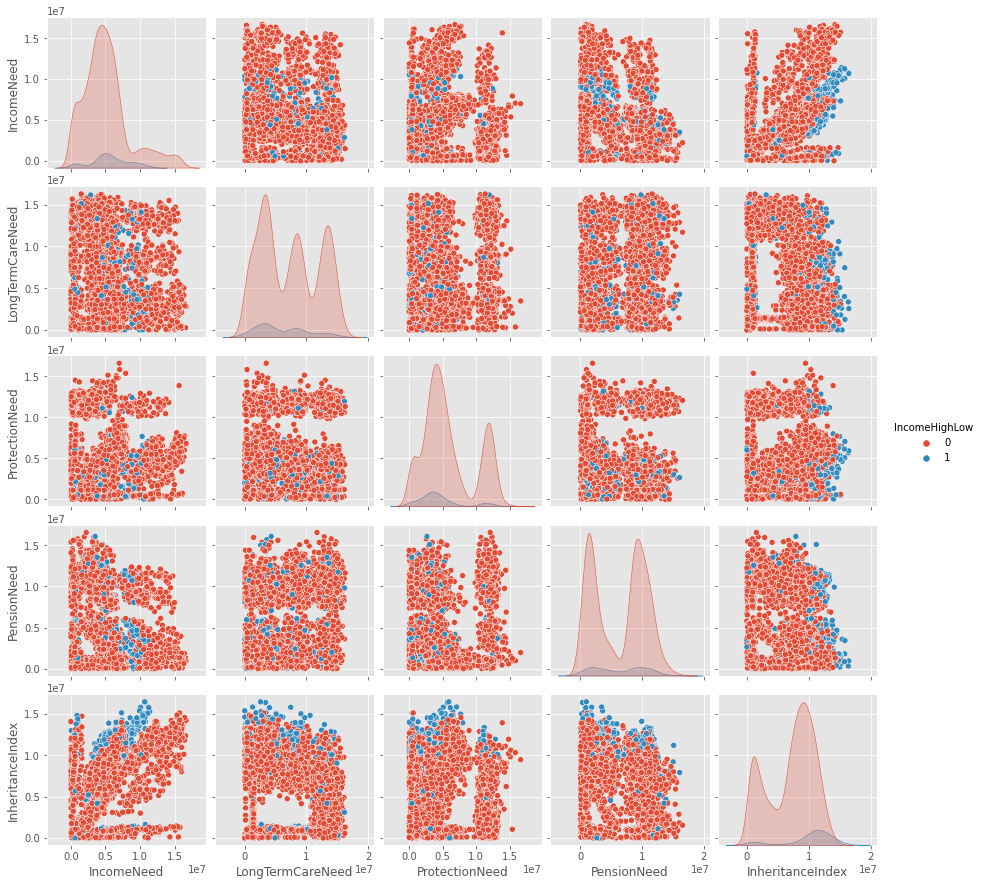

In [ ]:
sns.pairplot(CC[["IncomeHighLow",'IncomeNeed',
 'LongTermCareNeed',
 'ProtectionNeed',
 'PensionNeed',
 'InheritanceIndex',]],hue='IncomeHighLow',size=2.5)

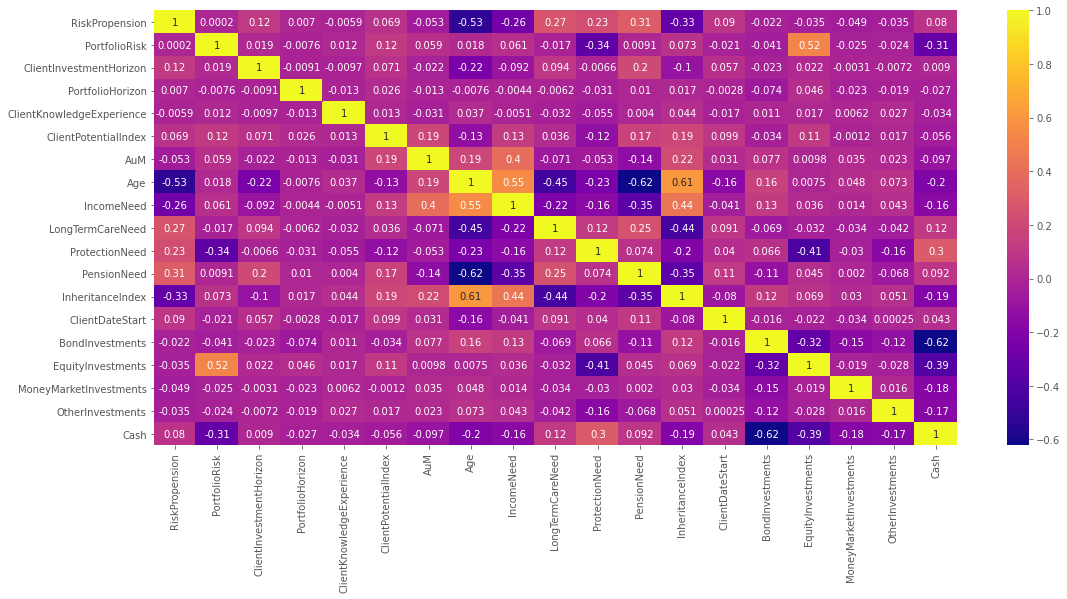

In [ ]:
plt.figure(figsize=(18, 8))
sns.heatmap(CC.corr(), cmap = "plasma" ,annot=True)

step 2 completed

In [ ]:
# All that's left is the standardization
from sklearn.preprocessing import StandardScaler

stand = col[:6] + col[10:15]

X = CC[[c for c in CC.columns if c in stand]]

scaler = StandardScaler()

X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=stand)

In [ ]:
X.head()

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex
0,0.838331,-1.046419,-0.040859,-0.046942,-0.952059,-0.415306,-1.136689,1.316772,-0.620746,1.004612,-1.425377
1,0.314565,0.506618,-0.335083,-0.046933,0.903107,-0.391850,-0.133382,-0.919807,-0.846875,0.986910,0.274194
2,0.601465,-1.068620,3.155574,-0.047200,0.078589,0.104076,-1.467906,1.623733,-1.188003,1.122199,-1.620674
3,-0.016690,-0.250752,2.557031,-0.046993,0.490848,-0.736989,-0.490271,0.421566,-0.523637,-0.629536,-0.116113
4,0.527424,-0.111377,-0.406893,-0.047021,-0.333670,-0.338237,0.057400,1.712241,1.602762,0.503663,-0.466914


In [ ]:
#import PCA
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
x_pca = pca.transform(X)

In [ ]:
X.shape

(5000, 11)

In [ ]:
x_pca.shape

(5000, 2)

In [ ]:
pca.explained_variance_ratio_

array([0.22361769, 0.13111808])

Text(0, 0.5, 'Second Principal Component')

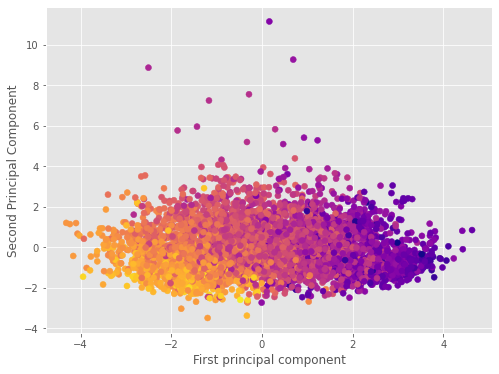

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=CC['Age'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [ ]:
"""

The components correspond to a combination of features from your dataset. 
The components themselves are stored as an attribute to the pca object

"""
pca.components_ 
# Each row represents a principal component and each column actually relates back to the original features

array([[ 0.39559412, -0.10580192,  0.17003606, -0.0080423 , -0.03426846,
        -0.04783485, -0.42372726,  0.38780137,  0.25825847,  0.40179716,
        -0.49173032],
       [ 0.11696437,  0.53619064,  0.28199974,  0.05684013,  0.08218276,
         0.51577041,  0.0382892 ,  0.10064559, -0.47759491,  0.31384724,
         0.0714043 ]])

In [ ]:
#let's transform this array into a df

df_comp = pd.DataFrame(pca.components_,columns=X.columns)
df_comp

,RiskPropension,PortfolioRisk,ClientInvestmentHorizon,PortfolioHorizon,ClientKnowledgeExperience,ClientPotentialIndex,IncomeNeed,LongTermCareNeed,ProtectionNeed,PensionNeed,InheritanceIndex
0,0.395594,-0.105802,0.170036,-0.008042,-0.034268,-0.047835,-0.423727,0.387801,0.258258,0.401797,-0.491730
1,0.116964,0.536191,0.282000,0.056840,0.082183,0.515770,0.038289,0.100646,-0.477595,0.313847,0.071404


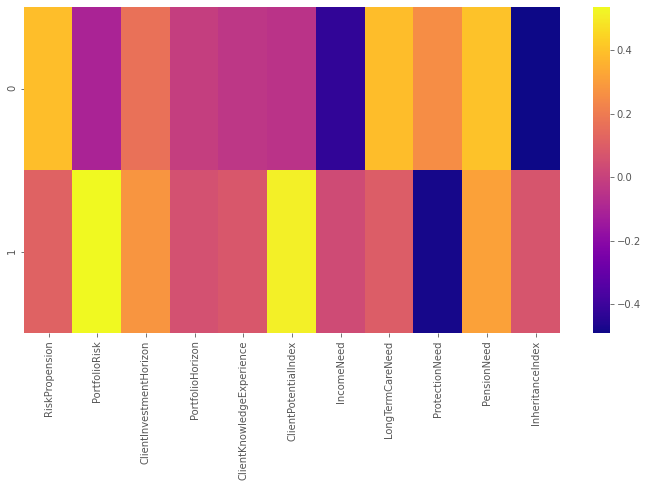

In [ ]:
"""
If we create a heatmap now we will be able to see the correlation between various features and the principal components themselves

basically each principal comp is shown here as a row and the more yellow the color then it's more correlated to a feature in the column 
In that way you can see which features are more important for each principal component 
"""


plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma')

In [ ]:
# Subset needed:
# - Age distribution... blavbla

# *Unsupervised Learning*

In [ ]:
# Link utile: https://towardsdatascience.com/centroid-neural-network-an-efficient-and-stable-clustering-algorithm-b7b385e1b8d

In [ ]:
X.head()
y = CCdiscrete["IncomeNeed"]

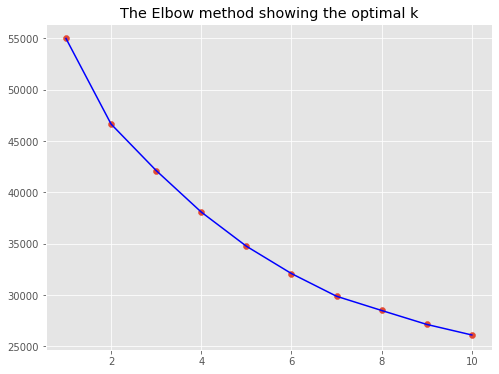

In [ ]:
elbow_method(X, 10, mod = "kmeans")
# between 4 and 6 optimal cluster I would say (most likely 4)

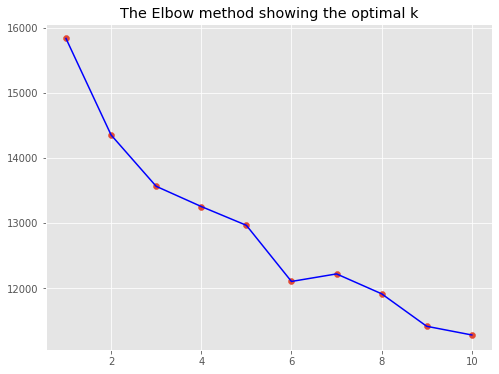

In [ ]:
elbow_method(X, 10, mod = "kmedoids")
# 3-4 optimal cluster I would guess

In [ ]:
# hypotesis / trade off between the two methods
optimal_number = 3

In [ ]:
kmeans2 = KMeans(n_clusters=optimal_number,init='k-means++', random_state=rstate)
y_pred1 = kmeans2.fit_predict(X)

In [ ]:
evaluation_metrics_Kmeans = evaluation_metrics(X, y_pred1,"euclidean","k-means++",y)

In [ ]:
evaluation_metrics_Kmeans

,Metric,Value,Algorithm
0,S_S,0.170545,k-means++
1,Purity,0.428000,k-means++


In [ ]:
kmedoids = KMedoids(n_clusters= optimal_number, metric = "euclidean", random_state=rstate)
predic_kmedoids = kmedoids.fit_predict(X)
predic_kmedoids

array([0, 2, 0, ..., 0, 1, 0])

In [ ]:
evaluation_metrics_Kmedoids = evaluation_metrics(X,predic_kmedoids, "euclidean", "kmedoids",y)#write your code here

In [ ]:
evaluation_metrics_Kmedoids

,Metric,Value,Algorithm
0,S_S,0.128805,kmedoids
1,Purity,0.446200,kmedoids


In [ ]:
kmeans_plus = KMeans(n_clusters = optimal_number = 4,init = 'k-means++', max_iter = 300, n_init = 10, random_state = rstate)
kmeans_plus.fit_predict(X)

SyntaxError: ignored

In [ ]:
kmedoids = KMedoids(n_clusters=3, random_state=rstate)
kmedoids.fit_predict(X)

In [ ]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)

In [ ]:
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=CC["ClientPotentialIndex"], s=50, cmap='viridis');
plt.title("Reference plot")

In [ ]:
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans_plus.labels_, s=50, cmap='viridis');
plt.title("K means")


In [ ]:

plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmedoids.labels_, s=50, cmap='viridis');
plt.title("K medoids")

# *Supervised Learning*

In [ ]:
# CERCARE PORTAFOGLIO CLIENTI!

In [ ]:
CCdiscrete.head()

In [ ]:
CCdiscrete.info()

In [ ]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = rstate

In [ ]:
X_feature = CC[stripcol].copy()

In [ ]:
X_feature.update(CCdiscrete["RiskPropension"])
X_feature.head()

In [ ]:
X_feature.isnull().sum().sum()

In [ ]:
X_feature.drop(columns=["RiskPropension"], inplace=True)
X_target = pd.DataFrame(CCdiscrete["RiskPropension"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_feature, X_target, test_size=0.3, random_state=RANDOM_SEED, stratify=X_target)

#### K-nearest neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.fit(X_train, y_train)

In [ ]:
neigh.score(X_test, y_test)

In [ ]:
neigh.predict(X_test)

#### Support vector machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(gamma="scale")

In [ ]:
svc.fit(X_train, y_train)

In [ ]:
svc.score(X_test, y_test)

In [ ]:
svc.predict(X_test)

In [ ]:
# When we give too much space for the margin, SVM can be underfitted, and it loses classification power. Too much generalization cannot always be good.

In [ ]:
svc = SVC(C = 0.1, gamma="scale")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

In sintesi occorre:

1. individuare bene obiettivi e bisogni dei clienti, segmentandoli opportunamente
2. individuare le caratteristiche salienti dei prodotti d’investimento
3. attuare il corretto abbinamento: cliente ↔ investmenti
4. monitorare e correggere eventuali anomalie e disallineamenti

Che cosa si va cercando?

1. Visione d’insieme
2. Fattispecie tipiche, ricorrenze
3. Similarità/dissimilarità tra clienti (clustering)
4. Strutture “nascoste” nei dati, e.g. relazioni
5. Importanza relative dei clienti (ranking)
6. Segmentazione dei clienti – difendibile e comprensibile

# *Neural Networks*